In [0]:
#Let us import all the dependencies for the model

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image
from IPython.display import Image, display


In [0]:
#Lets us create the content and style image path 
base_image_path = utils.get_file("paris.jpg","https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
result_prefix = "paris_generated"

In [0]:
# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [0]:
# Dimensions of the generated picture.
width, height = image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

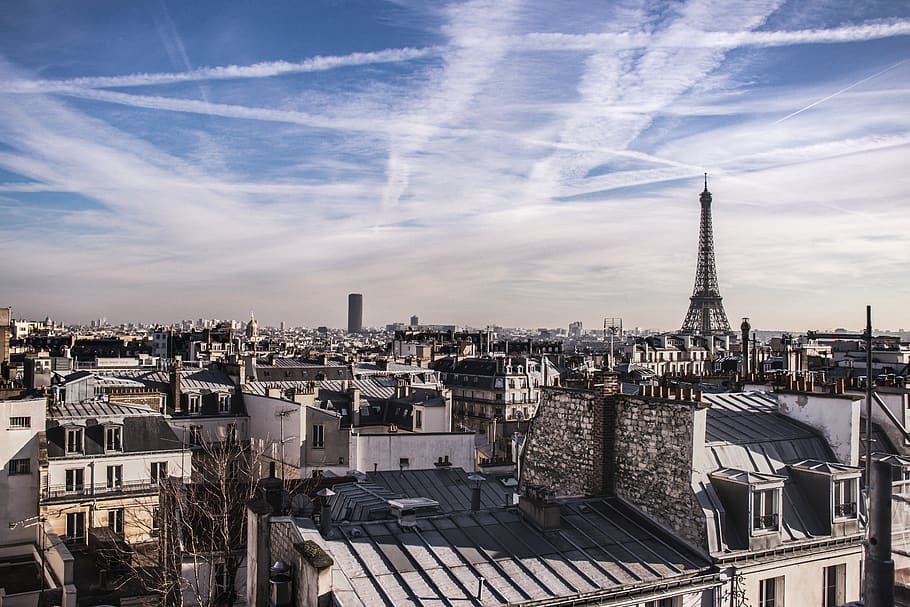

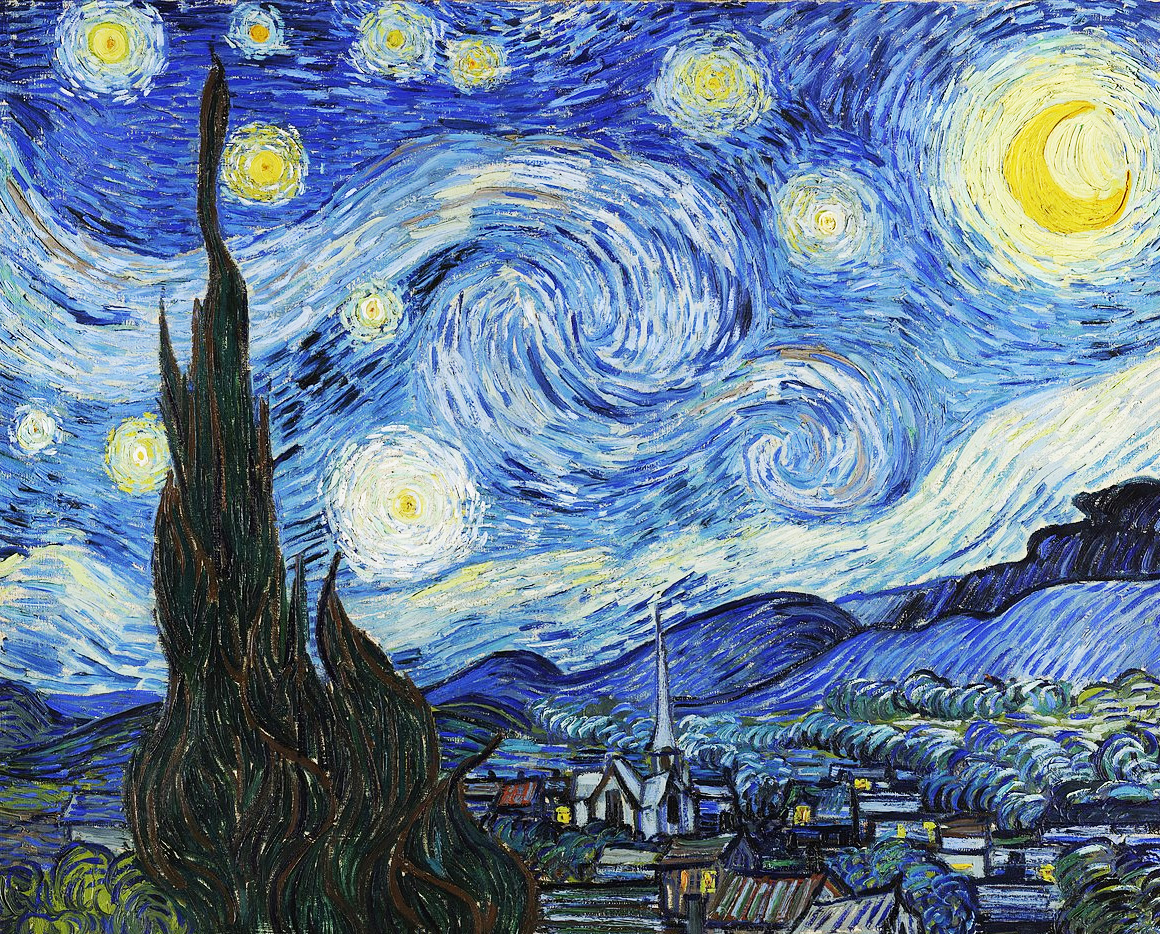

In [34]:
#Let's visualize the content and the style image
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [0]:
#Image Preprocessing
def preprocess_image(image_path):
  # Util function to open, resize and format pictures into appropriate tensors
  img = image.load_img(image_path,grayscale=False,target_size=(img_nrows,img_ncols))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  img = vgg19.preprocess_input(img)
  return tf.convert_to_tensor(img)

def deprocess_image(x):
  # Util function to convert a tensor into a valid image
  x = x.reshape((img_nrows, img_ncols, 3))
  # Remove zero-center by mean pixel
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # 'BGR'->'RGB'
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype("uint8")
  return x

Compute the Style Transfer loss and content loss

*   gram_matrix (used to compute the style loss)
*   The style_loss function, which keeps the generated image close to the local textures of the style reference image
*   The content_loss function, which keeps the high-level representation of the generated image close to that of the base image
*   The total_variation_loss function, a regularization loss which keeps the generated image locally-coherent


In [0]:
def gram_matrix(x):
  x = tf.transpose(x, (2, 0, 1))
  features = tf.reshape(x, (tf.shape(x)[0], -1))
  gram = tf.matmul(features, tf.transpose(features))
  return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_nrows * img_ncols
  return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
  return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
  a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
  b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
  return tf.reduce_sum(tf.pow(a + b, 1.25))

In [0]:
#Build a VGG19 model loaded with Pre-trained Imagenet weights
model = vgg19.VGG19(weights='imagenet',include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [0]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"

In [0]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [0]:
@tf.function
def compute_loss_and_grads(combination_image,base_image,style_reference_image):
  with tf.GradientTape() as tape:
    loss = compute_loss(combination_image,base_image,style_reference_image)
  grads = tape.gradient(loss,combination_image)
  return loss,grads


In [42]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(combination_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)


Iteration 100: loss=11017.99
Iteration 200: loss=8513.90
Iteration 300: loss=7571.32
Iteration 400: loss=7063.79
Iteration 500: loss=6735.97
Iteration 600: loss=6501.46
Iteration 700: loss=6322.95
Iteration 800: loss=6181.12
Iteration 900: loss=6065.04
Iteration 1000: loss=5967.44
Iteration 1100: loss=5884.38
Iteration 1200: loss=5812.72
Iteration 1300: loss=5750.29
Iteration 1400: loss=5695.55
Iteration 1500: loss=5647.19
Iteration 1600: loss=5604.13
Iteration 1700: loss=5565.46
Iteration 1800: loss=5530.70
Iteration 1900: loss=5499.22
Iteration 2000: loss=5470.60
Iteration 2100: loss=5444.50
Iteration 2200: loss=5420.63
Iteration 2300: loss=5398.71
Iteration 2400: loss=5378.52
Iteration 2500: loss=5359.90
Iteration 2600: loss=5342.71
Iteration 2700: loss=5326.79
Iteration 2800: loss=5312.05
Iteration 2900: loss=5298.31
Iteration 3000: loss=5285.50
Iteration 3100: loss=5273.56
Iteration 3200: loss=5262.41
Iteration 3300: loss=5252.00
Iteration 3400: loss=5242.23
Iteration 3500: loss=5

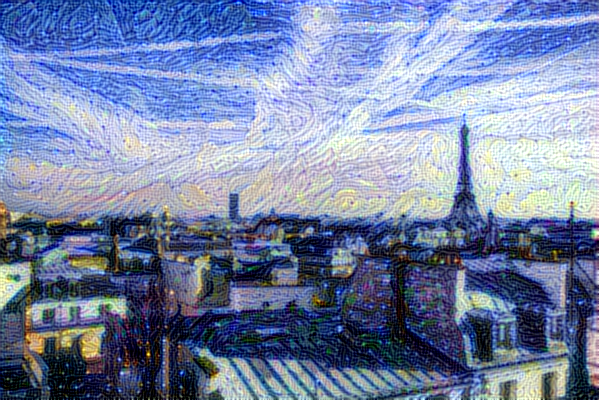

In [43]:
#Let us display the last iteration image
display(Image(result_prefix + "_at_iteration_4000.png"))

In [44]:
!ls

paris_generated_at_iteration_1000.png  paris_generated_at_iteration_2900.png
paris_generated_at_iteration_100.png   paris_generated_at_iteration_3000.png
paris_generated_at_iteration_1100.png  paris_generated_at_iteration_300.png
paris_generated_at_iteration_1200.png  paris_generated_at_iteration_3100.png
paris_generated_at_iteration_1300.png  paris_generated_at_iteration_3200.png
paris_generated_at_iteration_1400.png  paris_generated_at_iteration_3300.png
paris_generated_at_iteration_1500.png  paris_generated_at_iteration_3400.png
paris_generated_at_iteration_1600.png  paris_generated_at_iteration_3500.png
paris_generated_at_iteration_1700.png  paris_generated_at_iteration_3600.png
paris_generated_at_iteration_1800.png  paris_generated_at_iteration_3700.png
paris_generated_at_iteration_1900.png  paris_generated_at_iteration_3800.png
paris_generated_at_iteration_2000.png  paris_generated_at_iteration_3900.png
paris_generated_at_iteration_200.png   paris_generated_at_iteration_4000.png


In [0]:
#Let us download the final image 
from google.colab import files
files.download("paris_generated_at_iteration_4000.png")